# This notebook explores the use of a transformer model for predicting beaching locations with the Asia watershed

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Transformer
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from timeit import default_timer as timer
from tqdm import tqdm

In [3]:
# set random seed
seed = 42
torch.random.manual_seed(seed)
np.random.seed(seed)

In [4]:
# load data
Asia = pd.read_csv('selected_clusters/cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

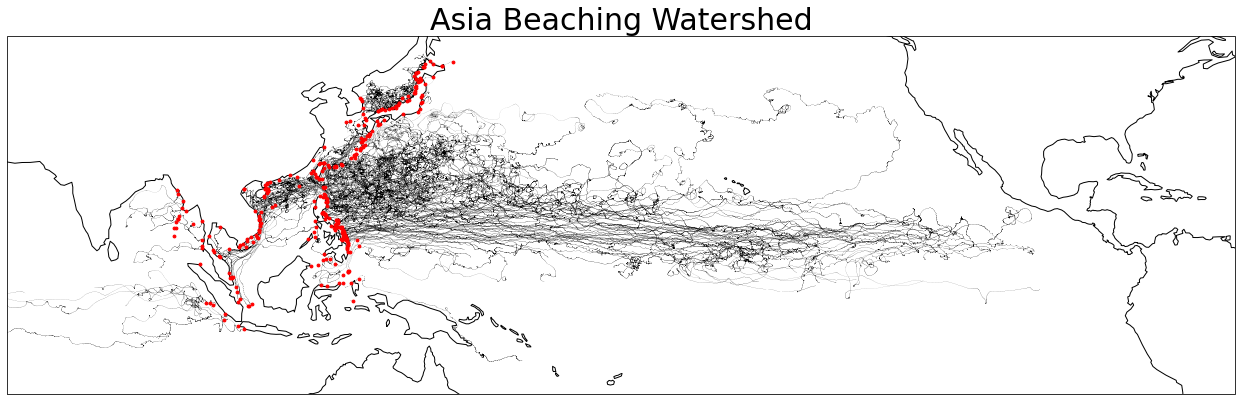

In [5]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by:
## 1. Applying a coordinate transform and normalizing
## 2. Splitting the trajectories into sub-sequences and those into source and target sequences
## 3. Splitting into train, test, and validation sets, convert to tensors
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a cartesian sphere. The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [6]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):

    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)

    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r)
    z = np.sin(lats_r)

    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))

    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)

    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

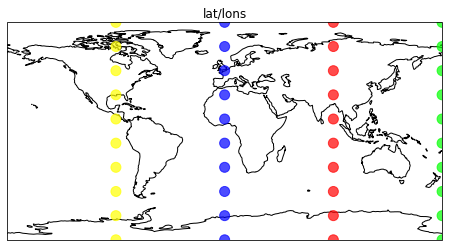

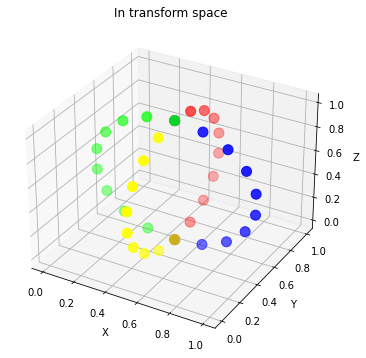

In [7]:
# now we apply this transform to some toy lat/lons:
toy_latitudes_1 = np.array(np.linspace(-90,90,10))
toy_longitudes_1 = np.array(np.ones(10) * 90)

toy_latitudes_2 = np.array(np.linspace(-90,90,10))
toy_longitudes_2 = np.array(np.ones(10) * 180)

toy_latitudes_3 = np.array(np.linspace(-90,90,10))
toy_longitudes_3 = np.array(np.zeros(10))

toy_latitudes_4 = np.array(np.linspace(-90,90,10))
toy_longitudes_4 = np.array(np.ones(10) * -90)

# concatenate toy lats/lons
toy_latitudes = np.concatenate((toy_latitudes_1, toy_latitudes_2, toy_latitudes_3, toy_latitudes_4))
toy_longitudes = np.concatenate((toy_longitudes_1, toy_longitudes_2, toy_longitudes_3, toy_longitudes_4))

# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

# apply coord transform to toy data
toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
point_size = 100
color1 = np.array([[255, 0, 0]] * 10) / 255.0  # Red
color2 = np.array([[0, 255, 0]] * 10) / 255.0  # Green
color3 = np.array([[0, 0, 255]] * 10) / 255.0  # Blue
color4 = np.array([[255, 255, 0]] * 10) / 255.0  # Yellow
colors = np.concatenate((color1, color2, color3, color4))
toy_scatter_red =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c=colors,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7)

plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100, c= colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [8]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()

# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

Asia_norm = Asia.drop(columns = ['lat', 'lon']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

### 2. Let's continue by breaking trajectories into sub-sequences of the same length and breaking those into source and target sequences

In [9]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id'
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index()

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR REDUCING INPUT DATA SIZE-------------------------------------------------------------------
#Asia_by_traj = Asia_by_traj[100:112]

In [10]:
# helper function for trajectory splitting
def sequence_splitting(feature, dataframe, sequence_length):

    # initialize output
    sequences = []

    # iterate through each trajectory
    for trajectory in dataframe[feature]:

        trajectory = np.array(trajectory) # convert to numpy array for faster processing

        # calculate the starting index to ensure the last sequence fits exactly
        # i.e, remove the first coords such that the length of the trajectory is divisible by the sequence length
        start_idx = len(trajectory) % sequence_length

        # split the trajectory into non-overlapping sequences of length sequence_length
        for i in range(start_idx, len(trajectory), sequence_length):
            if i + sequence_length <= len(trajectory):
                sequences.append(trajectory[i:i+sequence_length])

    return sequences

# helper function for src and tgt splitting
def src_tgt_splitting(feature, percent_src, sequence_length):

    # determine the length of src sequences
    src_length = int(sequence_length * percent_src / 100)

    # assign the first indices to src by percent_src
    src = [sequence[:src_length] for sequence in feature]

    # assign the remaining indices to tgt
    tgt = [sequence[src_length:] for sequence in feature]

    return (src, tgt)

# we define a function to split trajectories into sub-sequences and further split into src and tgt
# note that sequence_length should be equal to or less than min length of trajectories
def split_trajectories(dataframe, sequence_length, percent_src, input_features_list):

    # initialize output lists
    output_features_list = []
    src_tgt_features = []

    # split features of each trajectory into sequences of length sequence_length
    for feature in input_features_list:
        output_features_list.append(sequence_splitting(feature, dataframe, sequence_length))


    # split into src and tgt by percent_src
    for feature in output_features_list:
        src_tgt_features.append(src_tgt_splitting(feature, percent_src, sequence_length))

    return src_tgt_features

# perform the split into sequences of length 1000
sequence_length = 1000
percent_src = 50 # 50/50, SRC and TGT must have same length
src_tgt_features = split_trajectories(Asia_by_traj, sequence_length, percent_src, ['x','y','z'])

In [11]:
# check shape
print(np.shape(src_tgt_features))

(3, 2, 1241, 500)


In [12]:
# split xyz
x_src_tgt = src_tgt_features[0]
y_src_tgt = src_tgt_features[1]
z_src_tgt = src_tgt_features[2]

Text(0.5, 0.92, 'Sequences in Transform Space divided into Black SRC and Red TGT')

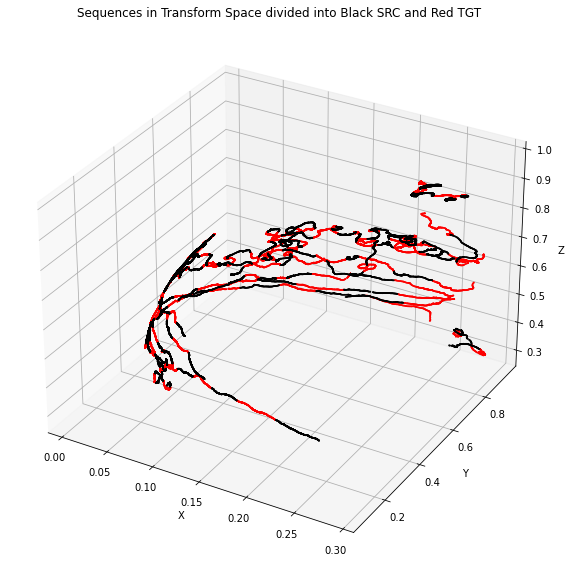

In [13]:
# visualize the SRC/TGT split
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_src_tgt[0][0:100], y_src_tgt[0][0:100],
           z_src_tgt[0][0:100], s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(x_src_tgt[1][0:100], y_src_tgt[1][0:100],
           z_src_tgt[1][0:100], s = 0.5, color ='r')


plt.title('Sequences in Transform Space divided into Black SRC and Red TGT')

In [14]:
# reduce the number of data by window averaging
def window_avg(data, window_size):
    
    # reshape the data to facilitate window averaging
    reshaped_data = data[:len(data) // window_size * window_size].reshape(-1, window_size)

    # calculate the mean along the last axis
    averaged_data = np.mean(reshaped_data, axis=1)

    return averaged_data

# get data from dataframe and apply reduction
window_size = 2 # set window_size

# apply window averaging to src
x_src = [window_avg(sequence, window_size) for sequence in x_src_tgt[0]]
y_src = [window_avg(sequence, window_size) for sequence in y_src_tgt[0]]
z_src = [window_avg(sequence, window_size) for sequence in z_src_tgt[0]]

# apply window averaging to tgt
x_tgt = [window_avg(sequence, window_size) for sequence in x_src_tgt[1]]
y_tgt = [window_avg(sequence, window_size) for sequence in y_src_tgt[1]]
z_tgt = [window_avg(sequence, window_size) for sequence in z_src_tgt[1]]

# combine src x,y,z together, stack, and transpose into shape [sequences, length, x y z]
all_src = np.transpose(np.stack([x_src, y_src, z_src], axis = 0), (1,2,0))
all_tgt = np.transpose(np.stack([x_tgt, y_tgt, z_tgt], axis = 0), (1,2,0))

In [15]:
# check shape
print(np.shape(all_src))
print(np.shape(all_src[0]))

(1241, 250, 3)
(250, 3)


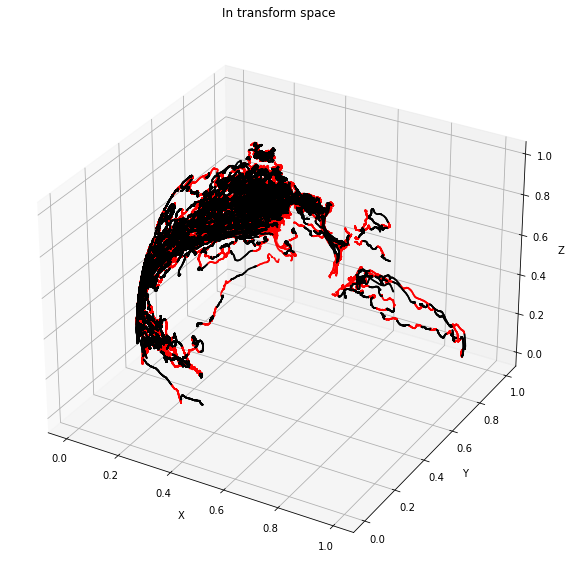

In [16]:
# let's take a look at the output of coordinate transformation, 
# normalization, sequencing, and splitting into src and tgt:
# x
Asia_src_x = all_src[:,:,0]
Asia_tgt_x = all_tgt[:,:,0]

# y
Asia_src_y = all_src[:,:,1]
Asia_tgt_y = all_tgt[:,:,1]

# z
Asia_src_z = all_src[:,:,2]
Asia_tgt_z = all_tgt[:,:,2]

# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_src_x, Asia_src_y,
           Asia_src_z, s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(Asia_tgt_x, Asia_tgt_y,
           Asia_tgt_z, s = 0.5, color ='r')
plt.title('In transform space')

plt.show()

### 3. Let's split into train, test, and validation sets, and also convert to tensors

In [17]:
# check number of sequences: 
print(np.shape(all_src[0]))

(250, 3)


In [18]:
# split data and input lengths into training and remaining (for validation and testing)
# train size should be less than number of sequences
train_src, remaining_src, train_tgt, remaining_tgt = train_test_split(
    all_src, all_tgt, train_size = 1201, random_state = 42)

# split the remaining data and input lengths into validation and test sets
# test size should be half of number of sequences - train size
val_src, test_src, val_tgt, test_tgt = train_test_split(
    remaining_src, remaining_tgt, test_size = 20, random_state = 42)


# GPU
# save as train, val, test of shape:[trajectories (batch), src or tgt, length (of trajectories), x y z (coordinate dimensions)]
#training_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(train_src, train_tgt)]
#validation_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(val_src, val_tgt)]
#testing_data = [(torch.tensor(src, dtype=torch.float32).cuda(), torch.tensor(tgt, dtype=torch.float32).cuda()) for src, tgt in zip(test_src, test_tgt)]

# CPU
# save as train, val, test of shape:[trajectories (batch), src or tgt, length (of trajectories), x y z (coordinate dimensions)]
training_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(train_src, train_tgt)]
validation_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(val_src, val_tgt)]
testing_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(test_src, test_tgt)]


In [19]:
# check shape, check tensor:
print(np.shape(training_data[0][0]))

torch.Size([250, 3])


### 4. Let's define the masking function

In [20]:
# helper function to generate a mask
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# define masking function
# assuming no padding is needed
def create_mask(src, tgt):
    
    # get src and tgt lengths where shape of both src and tgt is [batch, seq_len, features]
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    num_features = src.shape[1]

    # generate tgt mask
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # src mask is not needed
    src_mask = None
    
    # we aren't padding
    src_padding_mask = None
    tgt_padding_mask = None

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

### Define training and evaluation functions

In [21]:
# we define a function to train the model for a single epoch
def train_epoch(model, optimizer, training_data):
    
    # we're training
    model.train()
    
    # initialize loss list
    loss_list = []
    
    # assign input data
    train_iter = training_data
    
    # use DataLoader to split into batches
    # set shuffle to False as the data is sequential in time and space
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, shuffle=False)
    
    for src, tgt in train_dataloader:
        
        # separate learning for each epoch
        optimizer.zero_grad()
        
        # use all but the last step as input
        tgt_input = tgt[0, :-1, :]
        
        # use all but the first step as output
        tgt_out = tgt[0, 1:, :]

        # we need to mask the tgt
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # 1 step of model
        logits = model(src[0], tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        # compute loss
        loss = loss_fn(logits, tgt_out)
        
        # determine changes needed for each weight/bias for next epoch
        loss.backward()

        # apply gradient clipping to prevent explosion
        max_norm = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        # apply changes to weights/biases
        optimizer.step()
        
        # append loss to loss_list
        loss_list.append(loss.item())

    return loss_list

# define a function to evaluate the model
def evaluate(model, eval_data):
    
    # we're evaluating
    model.eval()

    # initialize out-lists
    loss_list = []
    logits_list = []
    tgt_out_list = []

    # assign input data
    eval_iter = eval_data

    # use DataLoader to split into batches
    # set shuffle to False as the data is sequential in time and space
    val_dataloader = DataLoader(eval_iter, batch_size=BATCH_SIZE, shuffle=False)

    for src, tgt in val_dataloader:
        
        # use all but the last step as input
        tgt_input = tgt[0, :-1, :]
        
        # use all but the first step as output
        tgt_out = tgt[0, 1:, :]
        
        # we need to mask the tgt
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        
        # apply the model to the evaluation data
        logits = model(src[0], tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        # save each loss term
        loss = loss_fn(logits, tgt_out)
        loss_list.append(loss.item())

        # save each model output term
        logits_list.append(logits)

        # save each tgt_out term
        tgt_out_list.append(tgt_out)

    return loss_list, logits_list, tgt_out_list

### Define transformer model

In [22]:
# define the transformer model
class Drifter_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 input_dim,
                 num_heads,
                 dim_feedforward=512,
                 dropout=0.1):
        super(Drifter_Transformer, self).__init__()

        # linear transformation of input_dim (coords) into higher space ()
        self.embedding = nn.Linear(input_dim, embedding_size)
        
        # apply the transformer
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        
        # output 3 values (x, y, z) through a linear layer
        self.generator = nn.Linear(embedding_size, 3)  

    def forward(self,
                src,
                tgt,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):

        # project input features to d_model dimensions
        src = self.embedding(src)
        tgt = self.embedding(tgt)

        # apply transformer
        outs = self.transformer(src, tgt, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        
        # return 3D linear-layer outs
        return self.generator(outs)

## Define hyperparameters

In [23]:
# set hyperparameters
#SRC_LENGTH = np.shape(train_src)[1]
#TGT_LENGTH = np.shape(train_tgt)[1]
INPUT_SIZE = 3 # xyz
EMB_SIZE = 550 # project into higher space
NUM_HEADS = 10 # EMB_SIZE should be divisible by this
FFN_HID_DIM = 512 # hidden dimenison size
BATCH_SIZE = 1 # batch size, used by DataLoader
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
NUM_EPOCHS = 8

# define model
transformer = Drifter_Transformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 INPUT_SIZE, NUM_HEADS, FFN_HID_DIM)

transformer = transformer#.cuda() # cuda is for GPU
model = transformer

# initialize parameters with xavier_uniform
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# define loss function
loss_fn = torch.nn.MSELoss()

# define optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

# initialize train and val loss lists
train_loss_list = []
val_loss_list = []

### Now, we train the model!

In [24]:
# train the model
for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, training_data)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss, _, _ = evaluate(transformer, validation_data)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))

 12%|█▎        | 1/8 [01:03<07:21, 63.02s/it]

Epoch: 1, Epoch time = 62.742s


 25%|██▌       | 2/8 [02:31<07:49, 78.18s/it]

Epoch: 2, Epoch time = 88.250s


 38%|███▊      | 3/8 [04:02<07:00, 84.02s/it]

Epoch: 3, Epoch time = 90.674s


 50%|█████     | 4/8 [05:36<05:50, 87.72s/it]

Epoch: 4, Epoch time = 93.030s


 62%|██████▎   | 5/8 [07:09<04:28, 89.61s/it]

Epoch: 5, Epoch time = 92.567s


 75%|███████▌  | 6/8 [08:41<03:00, 90.45s/it]

Epoch: 6, Epoch time = 91.709s


 88%|████████▊ | 7/8 [10:14<01:31, 91.36s/it]

Epoch: 7, Epoch time = 92.862s


100%|██████████| 8/8 [11:44<00:00, 88.06s/it]

Epoch: 8, Epoch time = 89.692s


final training loss: 0.006413370370864868
final validation loss: 6.610630225623026e-05


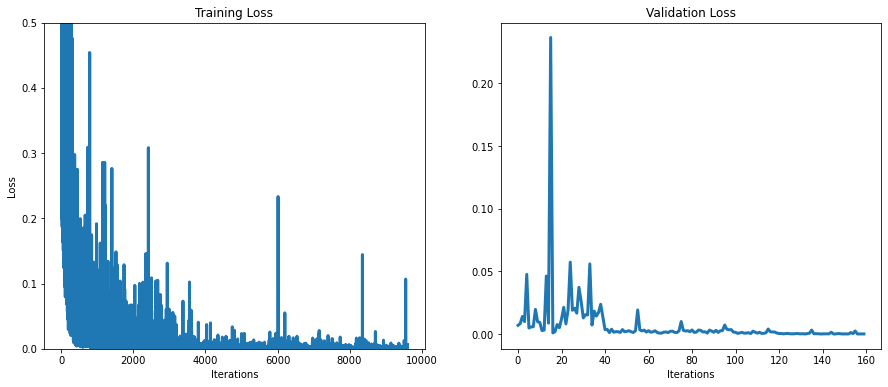

In [25]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(train_loss_list, linewidth=3, label='Training Loss')
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Iterations")
axs[0].set_title('Training Loss')
axs[0].set_ylim(0,0.5)

axs[1].plot(val_loss_list, linewidth=3, label='Validation Loss')
#axs[1].set_ylabel("Validation Loss")
axs[1].set_xlabel("Iterations")
axs[1].set_title('Validation Loss')

plt.show()

## let's test our model with our test data now!

In [26]:
# test with the test data

# initialize test_loss_list
test_loss_list = []

# run model with test data
test_loss, model_outputs, test_targets = evaluate(transformer, testing_data)

# append test_loss to the list
test_loss_list.extend(test_loss)

# print the final test loss value
print('final testing loss: '+ str(test_loss_list[-1]))

final testing loss: 7.064798410283402e-05


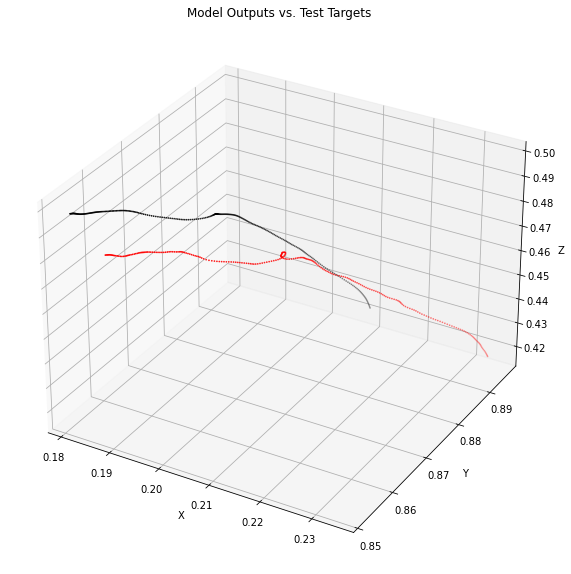

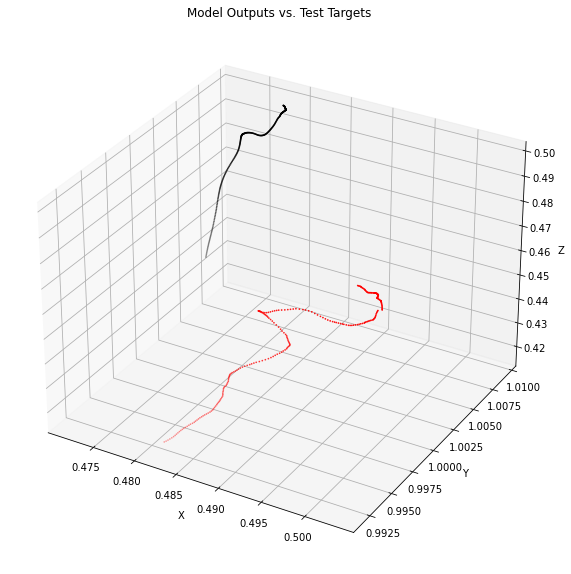

In [27]:
# Convert tensors to numpy arrays
model_outputs_np = model_outputs[0].cpu().detach().numpy()
test_targets_np = test_targets[0].cpu().detach().numpy()

model_outputs_np2 = model_outputs[1].cpu().detach().numpy()
test_targets_np2 = test_targets[1].cpu().detach().numpy()


# Extract the x, y, and z coordinates from both tensors
model_outputs_x = model_outputs_np[:, 0]
model_outputs_y = model_outputs_np[:, 1]
model_outputs_z = model_outputs_np[:, 2]

test_targets_x = test_targets_np[:, 0]
test_targets_y = test_targets_np[:, 1]
test_targets_z = test_targets_np[:, 2]

model_outputs_x2 = model_outputs_np2[:, 0]
model_outputs_y2 = model_outputs_np2[:, 1]
model_outputs_z2 = model_outputs_np2[:, 2]

test_targets_x2 = test_targets_np2[:, 0]
test_targets_y2 = test_targets_np2[:, 1]
test_targets_z2 = test_targets_np2[:, 2]

# Plot the model outputs and test targets in 3D space
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(model_outputs_x, model_outputs_y, model_outputs_z, s = 0.5, color ='k', label='Model Outputs')
ax.scatter(test_targets_x, test_targets_y, test_targets_z, s = 0.5, color ='r', label='Test Targets')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Model Outputs vs. Test Targets')

plt.show()
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(model_outputs_x2, model_outputs_y2, model_outputs_z, s = 0.5, color ='k', label='Model Outputs')
ax.scatter(test_targets_x2, test_targets_y2, test_targets_z, s = 0.5, color ='r', label='Test Targets')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Model Outputs vs. Test Targets')

plt.show()


### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [28]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):

    # initialize lat/lon list
    lon_list = []
    lat_list = []

    for sequence in model_outputs:
        for coord in sequence:

            # convert from tensor to list
            coord_list = coord.tolist()

            # undo MinMaxScaler normalization
            coord_list_denorm = coord_scaler.inverse_transform(np.array(coord_list).reshape(-1, 3)).squeeze()

            # extract x, y, z coords
            x = coord_list_denorm[0]
            y = coord_list_denorm[1]
            z = coord_list_denorm[2]

            # transform x, y, z back into lat/lon
            lons = np.degrees(np.arctan2(y, x))
            lats = np.degrees(np.arcsin(z))

            # append to a list
            lon_list.append(lons)
            lat_list.append(lats)

    return lat_list, lon_list

In [29]:
# apply function to convert x,y,z normalized values to denormalized lat/lon coords
# model outputs
lat_outputs, lon_outputs = inverse_coord_transform_normalize(model_outputs)

# targets
lat_targets, lon_targets = inverse_coord_transform_normalize(test_targets)

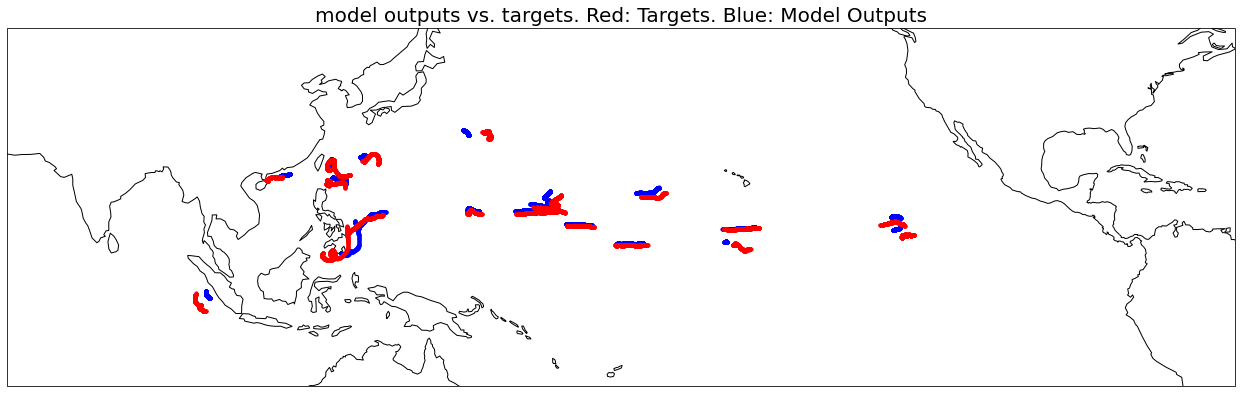

In [30]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

point_size = 10

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets. Red: Targets. Blue: Model Outputs', fontsize = 20)
plt.show()

Text(0.5, 1.0, 'closer view of results')

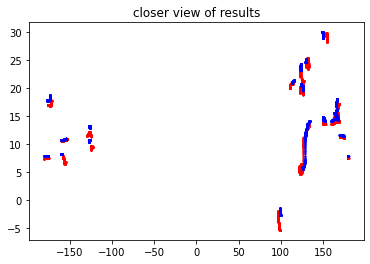

In [31]:
plt.scatter(lon_targets, lat_targets,s = 1, c = 'red')
plt.scatter(lon_outputs, lat_outputs, s = 1, c = 'blue')

plt.title('closer view of results')